[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/multiple-schemas.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239434-lesson-3-multiple-schemas)

# 多模式（Multiple Schemas）

## 回顾

我们刚刚介绍了状态模式和 reducers。

通常，所有图节点使用单一模式进行通信。

此外，这个单一模式包含图的输入和输出键/通道。

## 目标

但是，在某些情况下，我们可能需要对此进行更多控制：

* 内部节点可能传递在图的输入/输出中*不需要*的信息。

* 我们也可能想为图使用不同的输入/输出模式。例如，输出可能只包含单个相关的输出键。

我们将讨论几种使用多模式自定义图的方法。

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## 私有状态（Private State）

首先，让我们介绍在节点之间传递[私有状态](https://docs.langchain.com/oss/python/langgraph/use-graph-api#pass-private-state-between-nodes)的情况。

这对于图中间工作逻辑中需要的任何内容都很有用，但与整体图的输入或输出无关。

我们将定义一个 `OverallState` 和一个 `PrivateState`。

`node_2` 使用 `PrivateState` 作为输入，但输出到 `OverallState`。

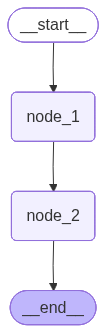

In [1]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int

def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"baz": state['foo'] + 1}

def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {"foo": state['baz'] + 1}

# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [2]:
graph.invoke({"foo" : 1})

---Node 1---
---Node 2---


/home/ruoshui/.conda/envs/langchain-academy/lib/python3.11/site-packages/pydantic/v1/main.py:1054: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)


{'foo': 3}

`baz` 只包含在 `PrivateState` 中。

`node_2` 使用 `PrivateState` 作为输入，但输出到 `OverallState`。

因此，我们可以看到 `baz` 被排除在图输出之外，因为它不在 `OverallState` 中。

## 输入/输出模式

默认情况下，`StateGraph` 接受单个模式，所有节点都应使用该模式进行通信。

然而，也可以[为图定义明确的输入和输出模式](https://docs.langchain.com/oss/python/langgraph/use-graph-api#define-input-and-output-schemas)。

在这些情况下，我们通常定义一个包含与图操作相关的*所有*键的"内部"模式。

但我们使用特定的 `input` 和 `output` 模式来约束输入和输出。

首先，让我们用单一模式运行图。

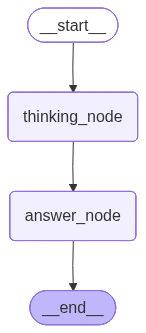

In [3]:
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: OverallState):
    return {"answer": "bye", "notes": "... his name is Lance"}

def answer_node(state: OverallState):
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

注意 invoke 的输出包含 `OverallState` 中的所有键。

In [4]:
graph.invoke({"question":"hi"})

{'question': 'hi', 'answer': 'bye Lance', 'notes': '... his name is Lance'}

现在，让我们为图使用特定的 `input` 和 `output` 模式。

这里，`input` / `output` 模式对图的输入和输出允许的键进行*过滤*。

此外，我们可以使用类型提示 `state: InputState` 来指定每个节点的输入模式。

当图使用多个模式时，这一点很重要。

我们在下面使用类型提示来展示，例如，`answer_node` 的输出将被过滤为 `OutputState`。

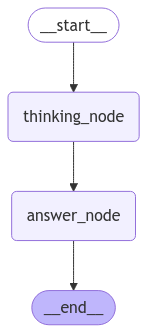

{'question': 'hi', 'answer': 'bye Lance', 'notes': '... his is name is Lance'}

In [ ]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState):
    return {"answer": "bye", "notes": "... his is name is Lance"}

def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question":"hi"})

我们可以看到 `output` 模式将输出约束为仅包含 `answer` 键。